## PLANT DISEASE DETECTION 

In [4]:
# Import necessary libraries for deep learning and computer vision
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
import time
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Configure device (GPU if available, otherwise CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Display system information
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")
print(f"PyTorch Version: {torch.__version__}")
print(f"Torchvision Version: {torchvision.__version__}")

Using device: cuda
GPU: NVIDIA GeForce RTX 4050 Laptop GPU
CUDA Version: 11.8
PyTorch Version: 2.5.1
Torchvision Version: 0.20.1


## DATASET EXPLORATION AND ANALYSIS

In [5]:
# Define dataset path (modify according to your dataset location)
dataset_path = r"C:\Users\User\Desktop\Workspace\NIBM\Current CWs\Computer Vision\plant-disease-detection\PlantVillage"

# Extract class names and count total classes
class_names = sorted(os.listdir(dataset_path))
num_classes = len(class_names)

print("="*60)
print("           DATASET EXPLORATION RESULTS")
print("="*60)
print(f"Total classes detected: {num_classes}")
print(f"First 5 classes: {class_names[:5]}")
print()

# Analyze class distribution for dataset balance assessment
class_counts = {}
total_images = 0

print("Analyzing class distribution...")
for class_name in class_names:
    class_path = os.path.join(dataset_path, class_name)
    # Count only image files (jpg, jpeg, png)
    image_files = [f for f in os.listdir(class_path) 
                   if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    count = len(image_files)
    class_counts[class_name] = count
    total_images += count

print(f"Total images in dataset: {total_images:,}")
print(f"Average images per class: {total_images // num_classes}")
print()

# Identify classes with most and least samples
sorted_counts = sorted(class_counts.items(), key=lambda x: x[1], reverse=True)
print("CLASS DISTRIBUTION ANALYSIS:")
print(f"Most samples: {sorted_counts[0][0]} - {sorted_counts[0][1]:,} images")
print(f"Least samples: {sorted_counts[-1][0]} - {sorted_counts[-1][1]:,} images")
print(f"Class imbalance ratio: {sorted_counts[0][1] / sorted_counts[-1][1]:.1f}:1")
print()

# Display all classes with their sample counts
print("COMPLETE CLASS BREAKDOWN:")
print("-" * 70)
for i, (class_name, count) in enumerate(sorted_counts):
    clean_name = class_name.replace('___', ' - ').replace('_', ' ')
    print(f"{i+1:2d}. {clean_name:<35} | {count:4d} images ({count/total_images*100:5.1f}%)")

           DATASET EXPLORATION RESULTS
Total classes detected: 15
First 5 classes: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

Analyzing class distribution...
Total images in dataset: 20,638
Average images per class: 1375

CLASS DISTRIBUTION ANALYSIS:
Most samples: Tomato__Tomato_YellowLeaf__Curl_Virus - 3,208 images
Least samples: Potato___healthy - 152 images
Class imbalance ratio: 21.1:1

COMPLETE CLASS BREAKDOWN:
----------------------------------------------------------------------
 1. Tomato  Tomato YellowLeaf  Curl Virus | 3208 images ( 15.5%)
 2. Tomato Bacterial spot               | 2127 images ( 10.3%)
 3. Tomato Late blight                  | 1909 images (  9.2%)
 4. Tomato Septoria leaf spot           | 1771 images (  8.6%)
 5. Tomato Spider mites Two spotted spider mite | 1676 images (  8.1%)
 6. Tomato healthy                      | 1591 images (  7.7%)
 7. Pepper  bell - healthy        

## SAMPLE DATA VISUALIZATION

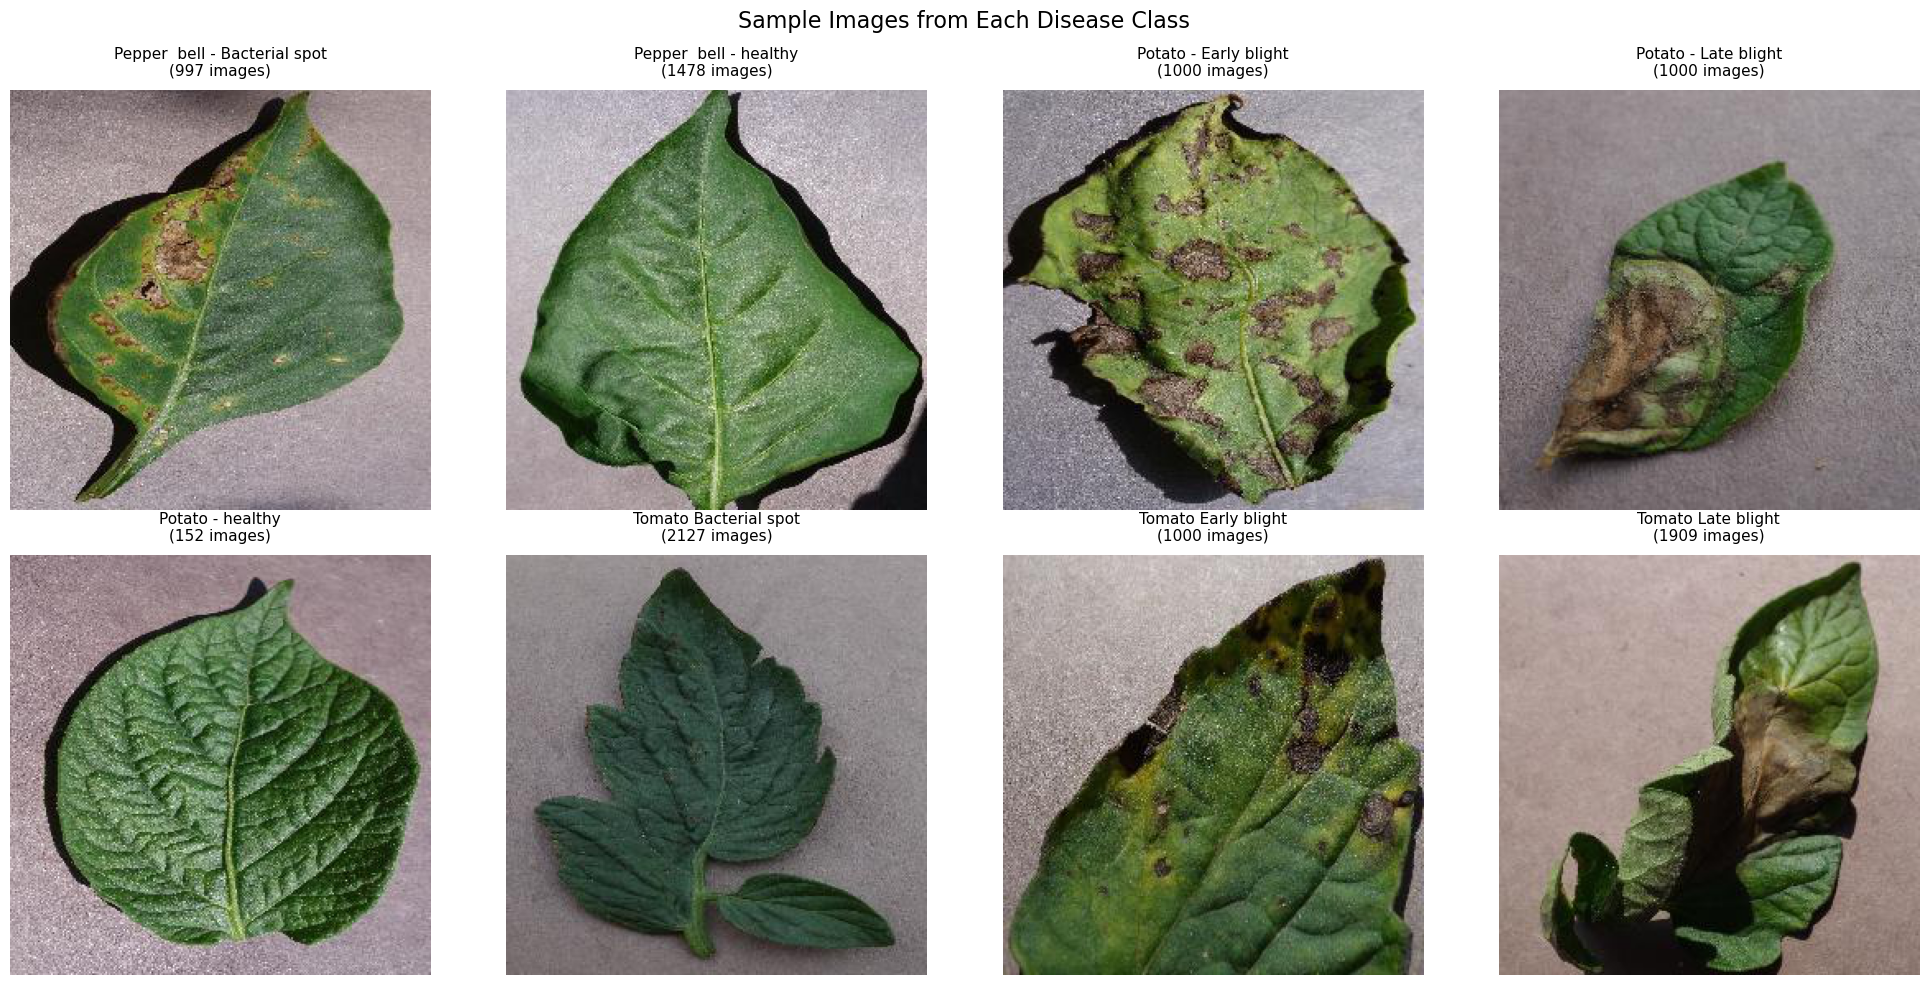

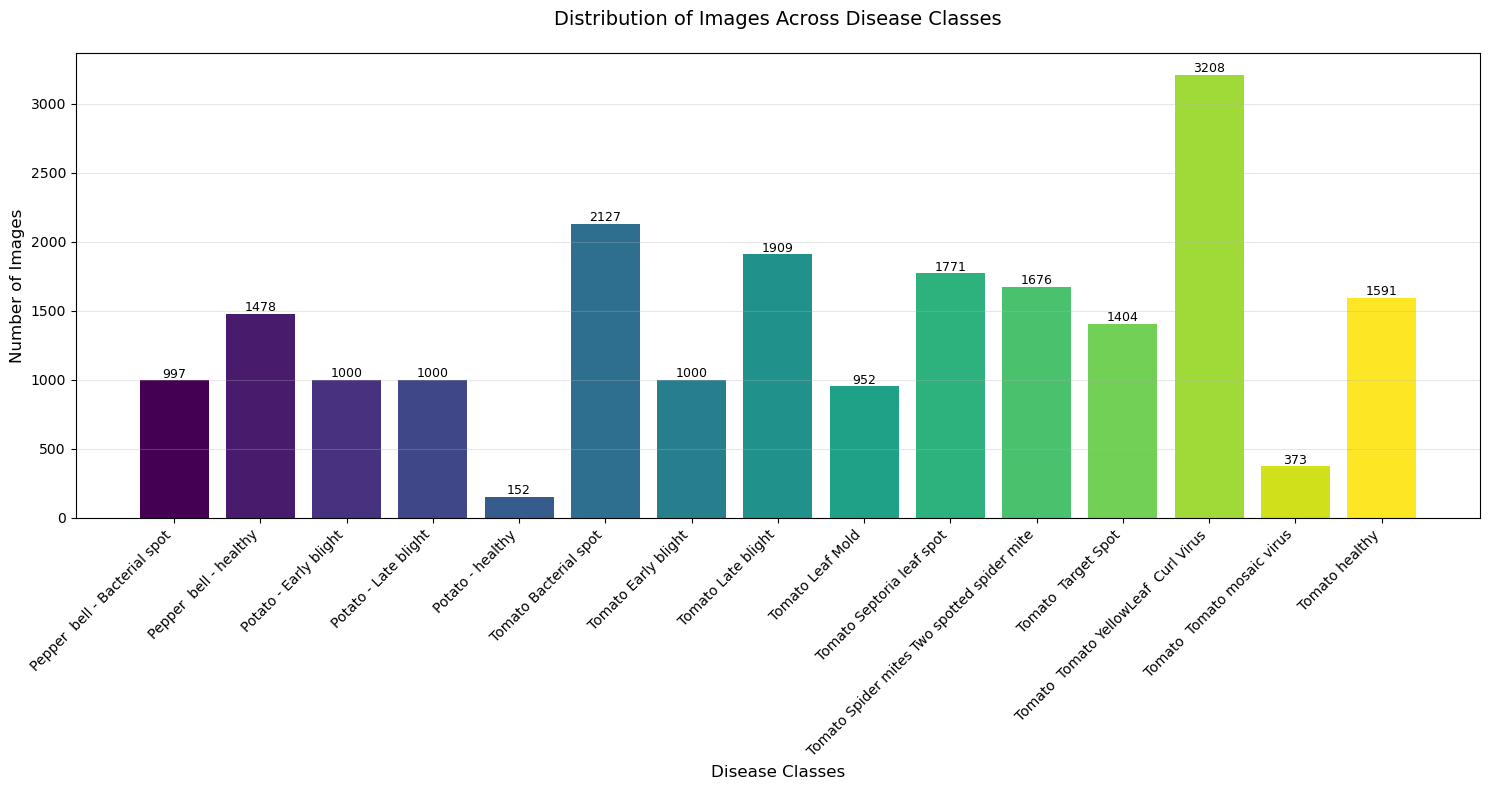

DATASET BALANCE STATISTICS:
Mean images per class: 1375.9
Standard deviation: 719.2
Coefficient of variation: 0.52


In [6]:
def display_class_samples(num_classes_to_show=8):
    """
    Display sample images from different classes to understand data diversity
    """
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.flatten()
    
    for i in range(min(num_classes_to_show, len(class_names))):
        class_name = class_names[i]
        class_path = os.path.join(dataset_path, class_name)
        image_files = [f for f in os.listdir(class_path) 
                       if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        
        if image_files:
            # Load and display first image from class
            img_path = os.path.join(class_path, image_files[0])
            img = Image.open(img_path)
            
            axes[i].imshow(img)
            # Clean class name for display
            clean_name = class_name.replace('___', ' - ').replace('_', ' ')
            axes[i].set_title(f"{clean_name}\n({class_counts[class_name]} images)", 
                            fontsize=11, pad=10)
            axes[i].axis('off')
    
    # Remove unused subplots
    for i in range(num_classes_to_show, len(axes)):
        axes[i].remove()
    
    plt.suptitle('Sample Images from Each Disease Class', fontsize=16, y=0.98)
    plt.tight_layout()
    plt.subplots_adjust(top=0.90)
    plt.show()

# Display sample images
display_class_samples()

def plot_class_distribution():
    """
    Create visualization of class distribution for dataset balance analysis
    """
    plt.figure(figsize=(15, 8))
    
    # Prepare data for plotting
    classes = [name.replace('___', ' - ').replace('_', ' ') for name in class_names]
    counts = [class_counts[name] for name in class_names]
    
    # Create bar plot
    bars = plt.bar(range(len(classes)), counts, 
                   color=plt.cm.viridis(np.linspace(0, 1, len(classes))))
    
    plt.title('Distribution of Images Across Disease Classes', fontsize=14, pad=20)
    plt.xlabel('Disease Classes', fontsize=12)
    plt.ylabel('Number of Images', fontsize=12)
    plt.xticks(range(len(classes)), classes, rotation=45, ha='right')
    
    # Add value labels on bars
    for bar, count in zip(bars, counts):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 20, 
                str(count), ha='center', fontsize=9)
    
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print("DATASET BALANCE STATISTICS:")
    print(f"Mean images per class: {np.mean(counts):.1f}")
    print(f"Standard deviation: {np.std(counts):.1f}")
    print(f"Coefficient of variation: {np.std(counts)/np.mean(counts):.2f}")

# Plot class distribution
plot_class_distribution()

## ADVANCED DATA PREPROCESSING AND AUGMENTATION

In [7]:
# Define comprehensive data augmentation for training

train_transforms = transforms.Compose([
    # Resize to standard input size for pre-trained models
    transforms.Resize((224, 224)),
    
    # Geometric augmentations to simulate different viewing angles
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomRotation(degrees=20),
    
    # Color augmentations to simulate different lighting conditions
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    
    # Advanced augmentations for better generalization
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.3),
    
    # Convert to tensor and normalize using ImageNet statistics
    # These statistics are optimal for transfer learning from ImageNet
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])
])

# Validation and test transforms 
val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])
])

print("Data preprocessing transforms defined:")
print("Training augmentations: Flip, Rotation, Color Jitter, Affine, Perspective")
print("Validation/Test: Resize and Normalize only")
print()

# Load the complete dataset
full_dataset = torchvision.datasets.ImageFolder(
    root=dataset_path,
    transform=train_transforms  # Will be modified for each split
)

print(f"Dataset loaded successfully:")
print(f"Total samples: {len(full_dataset):,}")
print(f"Number of classes: {len(full_dataset.classes)}")
print()

# Display class to index mapping for reference
print("CLASS TO INDEX MAPPING:")
print("-" * 50)
for class_name, idx in sorted(full_dataset.class_to_idx.items()):
    clean_name = class_name.replace('___', ' - ').replace('_', ' ')
    print(f"{idx:2d}: {clean_name}")

Data preprocessing transforms defined:
Training augmentations: Flip, Rotation, Color Jitter, Affine, Perspective
Validation/Test: Resize and Normalize only

Dataset loaded successfully:
Total samples: 20,638
Number of classes: 15

CLASS TO INDEX MAPPING:
--------------------------------------------------
 0: Pepper  bell - Bacterial spot
 1: Pepper  bell - healthy
 2: Potato - Early blight
 3: Potato - Late blight
 4: Potato - healthy
 5: Tomato Bacterial spot
 6: Tomato Early blight
 7: Tomato Late blight
 8: Tomato Leaf Mold
 9: Tomato Septoria leaf spot
10: Tomato Spider mites Two spotted spider mite
11: Tomato  Target Spot
12: Tomato  Tomato YellowLeaf  Curl Virus
13: Tomato  Tomato mosaic virus
14: Tomato healthy


## DATASET SPLITTING AND DATA LOADING

In [8]:
# Define dataset split ratios (following industry best practices)
dataset_size = len(full_dataset)
train_ratio = 0.70  # 70% for training
val_ratio = 0.15    # 15% for validation (hyperparameter tuning)
test_ratio = 0.15   # 15% for final evaluation

# Calculate actual sizes
train_size = int(train_ratio * dataset_size)
val_size = int(val_ratio * dataset_size)
test_size = dataset_size - train_size - val_size  # Ensure all samples are used

print("DATASET SPLITTING STRATEGY:")
print("=" * 50)
print(f"Total dataset size: {dataset_size:,} images")
print(f"Training set:   {train_size:,} images ({train_size/dataset_size*100:.1f}%)")
print(f"Validation set: {val_size:,} images ({val_size/dataset_size*100:.1f}%)")
print(f"Test set:       {test_size:,} images ({test_size/dataset_size*100:.1f}%)")
print()

# Perform random split with fixed seed for reproducibility
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    full_dataset, 
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)  # Fixed seed for reproducible results
)

# Apply appropriate transforms to each dataset split
# Training: with augmentation for better generalization
# Validation/Test: without augmentation for consistent evaluation
train_dataset.dataset.transform = train_transforms
val_dataset.dataset.transform = val_test_transforms  
test_dataset.dataset.transform = val_test_transforms

print("Dataset transforms applied:")
print("Training: Augmented transforms (flip, rotation, color jitter)")
print("Validation: Standard transforms (resize, normalize)")
print("Test: Standard transforms (resize, normalize)")
print()

# Configure data loading parameters for optimal performance
batch_size = 32          # Balanced batch size for memory efficiency
num_workers = 2          # Parallel data loading
pin_memory = True        # Faster GPU transfer

# Create data loaders for efficient batch processing
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,           # Shuffle training data for better learning
    num_workers=num_workers,
    pin_memory=pin_memory
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,          # No shuffling needed for validation
    num_workers=num_workers,
    pin_memory=pin_memory
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,          # No shuffling needed for testing
    num_workers=num_workers,
    pin_memory=pin_memory
)

print("DATA LOADERS CONFIGURATION:")
print(f"Batch size: {batch_size}")
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

DATASET SPLITTING STRATEGY:
Total dataset size: 20,638 images
Training set:   14,446 images (70.0%)
Validation set: 3,095 images (15.0%)
Test set:       3,097 images (15.0%)

Dataset transforms applied:
Training: Augmented transforms (flip, rotation, color jitter)
Validation: Standard transforms (resize, normalize)
Test: Standard transforms (resize, normalize)

DATA LOADERS CONFIGURATION:
Batch size: 32
Training batches: 452
Validation batches: 97
Test batches: 97


## DATA PIPELINE TESTING AND VALIDATION

In [9]:
print("Testing data pipeline integrity...")
print("-" * 40)

try:
    # Test data loading and processing
    train_iter = iter(train_loader)
    sample_batch = next(train_iter)
    images, labels = sample_batch
    
    # Validate batch dimensions and data types
    print("Data Pipeline Validation Results:")
    print(f"  Batch image shape: {images.shape}")
    print(f"  Batch labels shape: {labels.shape}")
    print(f"  Image data type: {images.dtype}")
    print(f"  Labels data type: {labels.dtype}")
    print(f"  Image value range: [{images.min():.3f}, {images.max():.3f}]")
    
    # Verify normalization (should be roughly [-2, 2] for ImageNet normalization)
    if -3 < images.min() < -1 and 1 < images.max() < 3:
        print("Normalization appears correct")
    else:
        print("Normalization may need verification")
    
    # Check label distribution in sample batch
    unique_labels = torch.unique(labels)
    print(f"  Unique labels in batch: {len(unique_labels)} out of {num_classes} classes")
    print(f"  Sample labels: {labels[:10].tolist()}")
    
    # Test GPU transfer capability
    print("\nGPU Transfer Test:")
    device_images = images.to(device)
    device_labels = labels.to(device)
    print(f"  Successfully moved batch to {device}")
    print(f"  GPU memory usage: {torch.cuda.memory_allocated() / 1024**2:.1f} MB" if device.type == 'cuda' else "  CPU usage confirmed")
    
except Exception as e:
    print(f"Data pipeline error: {e}")
    print("Please check dataset path and structure")

print("\nDATA PIPELINE READY FOR MODEL TRAINING")

Testing data pipeline integrity...
----------------------------------------
Data Pipeline Validation Results:
  Batch image shape: torch.Size([32, 3, 224, 224])
  Batch labels shape: torch.Size([32])
  Image data type: torch.float32
  Labels data type: torch.int64
  Image value range: [-2.101, 2.341]
Normalization appears correct
  Unique labels in batch: 10 out of 15 classes
  Sample labels: [10, 7, 1, 5, 12, 5, 5, 12, 2, 5]

GPU Transfer Test:
  Successfully moved batch to cuda
  GPU memory usage: 18.4 MB

DATA PIPELINE READY FOR MODEL TRAINING


## MODEL ARCHITECTURE DESIGN AND SETUP

In [10]:
def create_resnet50_model():
   
    # Create ResNet50 model with transfer learning
    print("Creating ResNet50 model...")
    
    # Load pre-trained ResNet50 with ImageNet weights
    model = torchvision.models.resnet50(weights='ResNet50_Weights.IMAGENET1K_V1')
    
    # Freeze all pre-trained layers (feature extraction approach)
    # This preserves the learned ImageNet features
    for param in model.parameters():
        param.requires_grad = False
    
    # Replace the final classification layer for our specific task
    # Original: 1000 classes (ImageNet) → Our task: 15 classes (plant diseases)
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, num_classes)
    
    print(f"  ResNet50 loaded with pre-trained ImageNet weights")
    print(f"  Final layer: {num_features} → {num_classes} classes")
    
    return model

def create_efficientnet_model():

    #Create EfficientNet-B0 model with transfer learning
    print("Creating EfficientNet-B0 model...")
    
    # Load pre-trained EfficientNet-B0 with ImageNet weights
    model = torchvision.models.efficientnet_b0(weights='EfficientNet_B0_Weights.IMAGENET1K_V1')
    
    # Freeze all pre-trained layers
    for param in model.parameters():
        param.requires_grad = False
    
    # Replace the final classification layer
    # EfficientNet uses a classifier module with dropout
    num_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_features, num_classes)
    
    print(f"  EfficientNet-B0 loaded with pre-trained ImageNet weights")
    print(f"  Final layer: {num_features} → {num_classes} classes")
    
    return model

# Initialize both models
print("INITIALIZING DEEP LEARNING MODELS")
print("=" * 50)

resnet_model = create_resnet50_model().to(device)
efficientnet_model = create_efficientnet_model().to(device)

print(f"\n Models moved to {device}")

# Display model information
def count_parameters(model):
    """Count trainable and total parameters"""
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total = sum(p.numel() for p in model.parameters())
    return trainable, total

resnet_trainable, resnet_total = count_parameters(resnet_model)
efficient_trainable, efficient_total = count_parameters(efficientnet_model)

print("\nMODEL PARAMETER ANALYSIS:")
print("-" * 30)
print(f"ResNet50:")
print(f"  Trainable parameters: {resnet_trainable:,}")
print(f"  Total parameters: {resnet_total:,}")
print(f"  Frozen parameters: {resnet_total - resnet_trainable:,}")

print(f"EfficientNet-B0:")
print(f"  Trainable parameters: {efficient_trainable:,}")
print(f"  Total parameters: {efficient_total:,}")
print(f"  Frozen parameters: {efficient_total - efficient_trainable:,}")

INITIALIZING DEEP LEARNING MODELS
Creating ResNet50 model...
  ResNet50 loaded with pre-trained ImageNet weights
  Final layer: 2048 → 15 classes
Creating EfficientNet-B0 model...
  EfficientNet-B0 loaded with pre-trained ImageNet weights
  Final layer: 1280 → 15 classes

 Models moved to cuda

MODEL PARAMETER ANALYSIS:
------------------------------
ResNet50:
  Trainable parameters: 30,735
  Total parameters: 23,538,767
  Frozen parameters: 23,508,032
EfficientNet-B0:
  Trainable parameters: 19,215
  Total parameters: 4,026,763
  Frozen parameters: 4,007,548


## TRAINING CONFIGURATION AND OPTIMIZATION SETUP

In [11]:
# Define loss function for multi-class classification
criterion = nn.CrossEntropyLoss()

# Configure optimizers for each model

learning_rate = 0.001  # Standard learning rate for transfer learning

resnet_optimizer = torch.optim.Adam(
    resnet_model.fc.parameters(),           # Only train the final layer
    lr=learning_rate,
    weight_decay=1e-4                       # L2 regularization to prevent overfitting
)

efficientnet_optimizer = torch.optim.Adam(
    efficientnet_model.classifier[1].parameters(),  # Only train the final layer
    lr=learning_rate,
    weight_decay=1e-4
)

# Learning rate scheduling for improved convergence
resnet_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    resnet_optimizer, mode='min', factor=0.5, patience=2, verbose=True
)

efficientnet_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    efficientnet_optimizer, mode='min', factor=0.5, patience=2, verbose=True
)

print("TRAINING CONFIGURATION:")
print("=" * 40)
print(f"Loss function: CrossEntropyLoss")
print(f"Optimizer: Adam with learning rate {learning_rate}")
print(f"L2 regularization: 1e-4")
print(f"LR scheduler: ReduceLROnPlateau (factor=0.5, patience=2)")
print(f"Training strategy: Transfer learning (feature extraction)")
print()

# Training hyperparameters
num_epochs = 5  # Sufficient for transfer learning with good pre-trained features
print(f"Training epochs: {num_epochs}")
print(f"Batch size: {batch_size}")
print(f"Dataset splits: {train_ratio:.0%} train, {val_ratio:.0%} val, {test_ratio:.0%} test")

print("\n Training setup completed")

TRAINING CONFIGURATION:
Loss function: CrossEntropyLoss
Optimizer: Adam with learning rate 0.001
L2 regularization: 1e-4
LR scheduler: ReduceLROnPlateau (factor=0.5, patience=2)
Training strategy: Transfer learning (feature extraction)

Training epochs: 5
Batch size: 32
Dataset splits: 70% train, 15% val, 15% test

 Training setup completed


## ENHANCED TRAINING FUNCTION WITH COMPREHENSIVE MONITORING

In [12]:
def train_model_enhanced(model, train_loader, val_loader, criterion, optimizer, 
                        scheduler, num_epochs=15, model_name="Model"):
    
    # Initialize tracking variables
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    learning_rates = []
    
    best_val_acc = 0.0
    best_model_state = None
    patience_counter = 0
    early_stopping_patience = 7  # Stop if no improvement for 7 epochs
    
    print(f"\n{'='*60}")
    print(f"           TRAINING {model_name.upper()}")
    print(f"{'='*60}")
    
    total_start_time = time.time()
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 50)
        
        epoch_start_time = time.time()
        
        # =====================
        # TRAINING PHASE
        # =====================
        model.train()  # Set model to training mode
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0
        
        # Training loop with progress monitoring
        for batch_idx, (images, labels) in enumerate(train_loader):
            # Move data to device
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            # Statistics tracking
            running_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
            
            # Progress reporting every 100 batches
            if (batch_idx + 1) % 100 == 0 or (batch_idx + 1) == len(train_loader):
                current_acc = 100 * correct_train / total_train
                print(f"  Batch {batch_idx+1:3d}/{len(train_loader)} | "
                      f"Loss: {loss.item():.4f} | Acc: {current_acc:.2f}%")
        
        # Calculate training metrics
        train_loss = running_train_loss / len(train_loader)
        train_acc = 100 * correct_train / total_train
        
        # =====================
        # VALIDATION PHASE
        # =====================
        model.eval()  # Set model to evaluation mode
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0
        
        with torch.no_grad():  # Disable gradient computation for efficiency
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                running_val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
        
        # Calculate validation metrics
        val_loss = running_val_loss / len(val_loader)
        val_acc = 100 * correct_val / total_val
        
        # Update learning rate scheduler
        scheduler.step(val_loss)
        current_lr = optimizer.param_groups[0]['lr']
        
        # Store metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        learning_rates.append(current_lr)
        
        # Calculate epoch time
        epoch_time = time.time() - epoch_start_time
        
        # Display epoch results
        print(f"\n  EPOCH {epoch+1} RESULTS:")
        print(f"    Training   → Loss: {train_loss:.4f} | Accuracy: {train_acc:.2f}%")
        print(f"    Validation → Loss: {val_loss:.4f} | Accuracy: {val_acc:.2f}%")
        print(f"    Learning Rate: {current_lr:.6f}")
        print(f"    Epoch Time: {epoch_time:.2f}s")
        
        # Model checkpointing - save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()
            patience_counter = 0
            print(f"    NEW BEST! Validation Accuracy: {best_val_acc:.2f}%")
        else:
            patience_counter += 1
            print(f"    No improvement ({patience_counter}/{early_stopping_patience})")
        
        # Early stopping check
        if patience_counter >= early_stopping_patience:
            print(f"\n    Early stopping triggered after {epoch+1} epochs")
            break
    
    # Load best model state
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"\n Best model loaded (Validation Accuracy: {best_val_acc:.2f}%)")
    
    total_time = time.time() - total_start_time
    print(f" {model_name} training completed in {total_time:.2f}s")
    
    return {
        'train_losses': train_losses,
        'val_losses': val_losses, 
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies,
        'learning_rates': learning_rates,
        'best_val_acc': best_val_acc,
        'total_epochs': len(train_losses),
        'training_time': total_time
    }

print("Enhanced training function defined with:")
print("Comprehensive progress monitoring")
print("Learning rate scheduling")
print("Model checkpointing")
print("Early stopping prevention")
print("Detailed performance tracking")

Enhanced training function defined with:
Comprehensive progress monitoring
Learning rate scheduling
Model checkpointing
Early stopping prevention
Detailed performance tracking


## RESNET50 MODEL TRAINING

In [13]:
print("Starting ResNet50 training...")

# Train ResNet50 model
resnet_history = train_model_enhanced(
    model=resnet_model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=resnet_optimizer,
    scheduler=resnet_scheduler,
    num_epochs=num_epochs,
    model_name="ResNet50"
)

# Display ResNet50 results summary
print(f"\n{'='*60}")
print(f"           RESNET50 TRAINING SUMMARY")
print(f"{'='*60}")
print(f"Best Validation Accuracy: {resnet_history['best_val_acc']:.2f}%")
print(f"Total Training Time: {resnet_history['training_time']:.2f}s")
print(f"Epochs Completed: {resnet_history['total_epochs']}")
print(f"Final Training Loss: {resnet_history['train_losses'][-1]:.4f}")
print(f"Final Validation Loss: {resnet_history['val_losses'][-1]:.4f}")

Starting ResNet50 training...

           TRAINING RESNET50

Epoch 1/5
--------------------------------------------------
  Batch 100/452 | Loss: 0.9449 | Acc: 59.84%
  Batch 200/452 | Loss: 0.5704 | Acc: 69.89%
  Batch 300/452 | Loss: 0.5538 | Acc: 74.55%
  Batch 400/452 | Loss: 0.3152 | Acc: 77.45%
  Batch 452/452 | Loss: 0.3851 | Acc: 78.53%

  EPOCH 1 RESULTS:
    Training   → Loss: 0.7682 | Accuracy: 78.53%
    Validation → Loss: 0.3794 | Accuracy: 89.05%
    Learning Rate: 0.001000
    Epoch Time: 77.47s
    NEW BEST! Validation Accuracy: 89.05%

Epoch 2/5
--------------------------------------------------
  Batch 100/452 | Loss: 0.5785 | Acc: 87.47%
  Batch 200/452 | Loss: 0.4797 | Acc: 87.31%
  Batch 300/452 | Loss: 0.1918 | Acc: 87.90%
  Batch 400/452 | Loss: 0.2789 | Acc: 88.52%
  Batch 452/452 | Loss: 0.3048 | Acc: 88.59%

  EPOCH 2 RESULTS:
    Training   → Loss: 0.3775 | Accuracy: 88.59%
    Validation → Loss: 0.2823 | Accuracy: 91.66%
    Learning Rate: 0.001000
    Epoch

## EFFICIENTNET-B0 MODEL TRAINING

In [14]:
print("Starting EfficientNet-B0 training...")

# Train EfficientNet-B0 model
efficientnet_history = train_model_enhanced(
    model=efficientnet_model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=efficientnet_optimizer,
    scheduler=efficientnet_scheduler,
    num_epochs=num_epochs,
    model_name="EfficientNet-B0"
)

# Display EfficientNet results summary
print(f"\n{'='*60}")
print(f"         EFFICIENTNET-B0 TRAINING SUMMARY")
print(f"{'='*60}")
print(f"Best Validation Accuracy: {efficientnet_history['best_val_acc']:.2f}%")
print(f"Total Training Time: {efficientnet_history['training_time']:.2f}s")
print(f"Epochs Completed: {efficientnet_history['total_epochs']}")
print(f"Final Training Loss: {efficientnet_history['train_losses'][-1]:.4f}")
print(f"Final Validation Loss: {efficientnet_history['val_losses'][-1]:.4f}")

Starting EfficientNet-B0 training...

           TRAINING EFFICIENTNET-B0

Epoch 1/5
--------------------------------------------------
  Batch 100/452 | Loss: 1.0298 | Acc: 63.06%
  Batch 200/452 | Loss: 0.6963 | Acc: 72.28%
  Batch 300/452 | Loss: 0.4800 | Acc: 76.69%
  Batch 400/452 | Loss: 0.3823 | Acc: 79.06%
  Batch 452/452 | Loss: 0.3533 | Acc: 79.93%

  EPOCH 1 RESULTS:
    Training   → Loss: 0.8075 | Accuracy: 79.93%
    Validation → Loss: 0.3725 | Accuracy: 90.82%
    Learning Rate: 0.001000
    Epoch Time: 71.52s
    NEW BEST! Validation Accuracy: 90.82%

Epoch 2/5
--------------------------------------------------
  Batch 100/452 | Loss: 0.5429 | Acc: 89.03%
  Batch 200/452 | Loss: 0.4415 | Acc: 88.95%
  Batch 300/452 | Loss: 0.5978 | Acc: 89.36%
  Batch 400/452 | Loss: 0.4434 | Acc: 89.49%
  Batch 452/452 | Loss: 0.2975 | Acc: 89.57%

  EPOCH 2 RESULTS:
    Training   → Loss: 0.3773 | Accuracy: 89.57%
    Validation → Loss: 0.2630 | Accuracy: 93.18%
    Learning Rate: 0.00

## MODEL PERFORMANCE COMPARISON 

In [15]:
print(f"\n{'='*70}")
print(f"                    MODEL COMPARISON ANALYSIS")
print(f"{'='*70}")

# Compare validation accuracies
resnet_best = resnet_history['best_val_acc']
efficientnet_best = efficientnet_history['best_val_acc']
accuracy_difference = abs(efficientnet_best - resnet_best)

print(f"\nVALIDATION ACCURACY COMPARISON:")
print(f"  ResNet50:       {resnet_best:.2f}%")
print(f"  EfficientNet:   {efficientnet_best:.2f}%")
print(f"  Difference:     {accuracy_difference:.2f}%")

# Compare training efficiency
resnet_time = resnet_history['training_time']
efficientnet_time = efficientnet_history['training_time']
time_difference = abs(efficientnet_time - resnet_time)

print(f"\nTRAINING EFFICIENCY COMPARISON:")
print(f"  ResNet50 time:      {resnet_time:.2f}s")
print(f"  EfficientNet time:  {efficientnet_time:.2f}s")
print(f"  Time difference:    {time_difference:.2f}s")

# Compare model complexity
resnet_params = sum(p.numel() for p in resnet_model.fc.parameters())
efficientnet_params = sum(p.numel() for p in efficientnet_model.classifier[1].parameters())

print(f"\nMODEL COMPLEXITY COMPARISON:")
print(f"  ResNet50 trainable params:       {resnet_params:,}")
print(f"  EfficientNet trainable params:   {efficientnet_params:,}")

# Determine the winner based on validation accuracy
if resnet_best > efficientnet_best:
    winner_name = "ResNet50"
    winner_model = resnet_model
    winner_history = resnet_history
    improvement = resnet_best - efficientnet_best
else:
    winner_name = "EfficientNet-B0"
    winner_model = efficientnet_model
    winner_history = efficientnet_history
    improvement = efficientnet_best - resnet_best

print(f"\nWINNER: {winner_name}")
print(f"   Validation Accuracy: {winner_history['best_val_acc']:.2f}%")
print(f"   Performance advantage: +{improvement:.2f}%")
print(f"   Training time: {winner_history['training_time']:.2f}s")

print(f"\n✓ Best performing model selected: {winner_name}")


                    MODEL COMPARISON ANALYSIS

VALIDATION ACCURACY COMPARISON:
  ResNet50:       93.25%
  EfficientNet:   94.64%
  Difference:     1.39%

TRAINING EFFICIENCY COMPARISON:
  ResNet50 time:      344.82s
  EfficientNet time:  358.51s
  Time difference:    13.69s

MODEL COMPLEXITY COMPARISON:
  ResNet50 trainable params:       30,735
  EfficientNet trainable params:   19,215

WINNER: EfficientNet-B0
   Validation Accuracy: 94.64%
   Performance advantage: +1.39%
   Training time: 358.51s

✓ Best performing model selected: EfficientNet-B0


## COMPREHENSIVE TEST SET EVALUATION

In [16]:
def evaluate_model_comprehensive(model, test_loader, class_names, model_name):
    
    print(f"\n{'='*60}")
    print(f"      COMPREHENSIVE EVALUATION: {model_name.upper()}")
    print(f"{'='*60}")
    
    model.eval()
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []
    all_probabilities = []
    
    print("Evaluating on test set...")
    
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(test_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            
            # Get probabilities for confidence analysis
            probabilities = torch.softmax(outputs, dim=1)
            all_probabilities.extend(probabilities.cpu().numpy())
            
            # Get predictions
            _, predicted = torch.max(outputs, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            # Progress indicator
            if (batch_idx + 1) % 25 == 0:
                current_acc = 100 * correct / total
                print(f"  Progress: {batch_idx+1}/{len(test_loader)} batches | "
                      f"Current accuracy: {current_acc:.2f}%")
    
    # Calculate primary metrics
    test_accuracy = 100 * correct / total
    
    # Calculate detailed metrics using sklearn
    precision, recall, f1, support = precision_recall_fscore_support(
        all_labels, all_predictions, average=None, zero_division=0
    )
    
    # Calculate weighted averages
    precision_weighted = precision_recall_fscore_support(all_labels, all_predictions, average='weighted')[0]
    recall_weighted = precision_recall_fscore_support(all_labels, all_predictions, average='weighted')[1]
    f1_weighted = precision_recall_fscore_support(all_labels, all_predictions, average='weighted')[2]
    
    # Calculate macro averages
    precision_macro = precision_recall_fscore_support(all_labels, all_predictions, average='macro')[0]
    recall_macro = precision_recall_fscore_support(all_labels, all_predictions, average='macro')[1]
    f1_macro = precision_recall_fscore_support(all_labels, all_predictions, average='macro')[2]
    
    return {
        'test_accuracy': test_accuracy,
        'predictions': all_predictions,
        'true_labels': all_labels,
        'probabilities': all_probabilities,
        'precision_per_class': precision,
        'recall_per_class': recall,
        'f1_per_class': f1,
        'support_per_class': support,
        'precision_weighted': precision_weighted,
        'recall_weighted': recall_weighted,
        'f1_weighted': f1_weighted,
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'f1_macro': f1_macro
    }

# Evaluate the winning model on test set
test_results = evaluate_model_comprehensive(
    winner_model, test_loader, class_names, winner_name
)

# Also evaluate ResNet50 on test set for complete comparison
print(f"\n" + "="*60)
print(f"     EVALUATING RESNET50 FOR COMPLETE COMPARISON")
print(f"="*60)

resnet_test_results = evaluate_model_comprehensive(
    resnet_model, test_loader, class_names, "ResNet50"
)

# Display comprehensive results
print(f"\n{'='*60}")
print(f"           FINAL TEST RESULTS: {winner_name.upper()}")
print(f"{'='*60}")

print(f"\nOVERALL PERFORMANCE METRICS:")
print(f"  Test Accuracy:      {test_results['test_accuracy']:.2f}%")
print(f"  Weighted Precision: {test_results['precision_weighted']:.4f}")
print(f"  Weighted Recall:    {test_results['recall_weighted']:.4f}")
print(f"  Weighted F1-Score:  {test_results['f1_weighted']:.4f}")
print(f"  Macro Precision:    {test_results['precision_macro']:.4f}")
print(f"  Macro Recall:       {test_results['recall_macro']:.4f}")
print(f"  Macro F1-Score:     {test_results['f1_macro']:.4f}")

print(f"\nMODEL PERFORMANCE CLASSIFICATION:")
accuracy = test_results['test_accuracy']
if accuracy >= 95:
    performance_level = "EXCELLENT"
elif accuracy >= 90:
    performance_level = "VERY GOOD"
elif accuracy >= 85:
    performance_level = "GOOD"
elif accuracy >= 80:
    performance_level = "FAIR"
else:
    performance_level = "NEEDS IMPROVEMENT"

print(f"  Performance Level: {performance_level}")


      COMPREHENSIVE EVALUATION: EFFICIENTNET-B0
Evaluating on test set...
  Progress: 25/97 batches | Current accuracy: 95.38%
  Progress: 50/97 batches | Current accuracy: 94.75%
  Progress: 75/97 batches | Current accuracy: 94.88%

     EVALUATING RESNET50 FOR COMPLETE COMPARISON

      COMPREHENSIVE EVALUATION: RESNET50
Evaluating on test set...
  Progress: 25/97 batches | Current accuracy: 93.50%
  Progress: 50/97 batches | Current accuracy: 93.44%
  Progress: 75/97 batches | Current accuracy: 93.71%

           FINAL TEST RESULTS: EFFICIENTNET-B0

OVERALL PERFORMANCE METRICS:
  Test Accuracy:      94.58%
  Weighted Precision: 0.9459
  Weighted Recall:    0.9458
  Weighted F1-Score:  0.9453
  Macro Precision:    0.9405
  Macro Recall:       0.9406
  Macro F1-Score:     0.9400

MODEL PERFORMANCE CLASSIFICATION:
  Performance Level: VERY GOOD


## DETAILED PER-CLASS ANALYSIS AND CONFUSION MATRIX

In [17]:
print(f"\n{'='*80}")
print(f"                    DETAILED PER-CLASS ANALYSIS")
print(f"{'='*80}")

# Create per-class performance analysis
class_performance = []
for i, class_name in enumerate(class_names):
    clean_name = class_name.replace('___', ' - ').replace('_', ' ')
    class_performance.append({
        'class': clean_name,
        'precision': test_results['precision_per_class'][i],
        'recall': test_results['recall_per_class'][i],
        'f1': test_results['f1_per_class'][i],
        'support': test_results['support_per_class'][i]
    })

# Sort by support (number of test samples) for better readability
class_performance.sort(key=lambda x: x['support'], reverse=True)

print(f"\nPER-CLASS PERFORMANCE METRICS (sorted by test samples):")
print("-" * 80)
print(f"{'Class Name':<35} | {'Precision':>9} | {'Recall':>9} | {'F1-Score':>9} | {'Samples':>7}")
print("-" * 80)

excellent_classes = 0
good_classes = 0
poor_classes = 0

for class_data in class_performance:
    precision = class_data['precision']
    recall = class_data['recall']
    f1 = class_data['f1']
    support = class_data['support']
    
    # Classify performance level
    if f1 >= 0.95:
        excellent_classes += 1
        perf_indicator = "Excellent"
    elif f1 >= 0.90:
        good_classes += 1
        perf_indicator = "Good"
    else:
        poor_classes += 1
        perf_indicator = "Needs Improvement"
    
    print(f"{class_data['class']:<35} | {precision:8.3f} | {recall:8.3f} | "
          f"{f1:8.3f} | {support:6d} {perf_indicator}")

print("-" * 80)
print(f"Performance Summary: {excellent_classes} excellent, {good_classes} good, {poor_classes} need improvement")

# Generate confusion matrix analysis
def analyze_confusion_matrix(true_labels, predictions, class_names):
    """
    Generate and analyze confusion matrix for classification errors
    """
    cm = confusion_matrix(true_labels, predictions)
    
    print(f"\n{'='*60}")
    print(f"              CONFUSION MATRIX ANALYSIS")
    print(f"{'='*60}")
    
    # Find most confused class pairs
    confused_pairs = []
    for i in range(len(cm)):
        for j in range(len(cm)):
            if i != j and cm[i][j] > 0:
                clean_true = class_names[i].replace('___', ' - ').replace('_', ' ')
                clean_pred = class_names[j].replace('___', ' - ').replace('_', ' ')
                confused_pairs.append((clean_true, clean_pred, cm[i][j]))
    
    # Sort by number of misclassifications
    confused_pairs.sort(key=lambda x: x[2], reverse=True)
    
    print(f"\nTOP 10 MOST CONFUSED CLASS PAIRS:")
    print("-" * 70)
    print(f"{'True Class':<25} | {'Predicted As':<25} | {'Count':>6}")
    print("-" * 70)
    
    for i, (true_class, predicted_class, count) in enumerate(confused_pairs[:10]):
        print(f"{true_class:<25} | {predicted_class:<25} | {count:6d}")
    
    # Calculate per-class error rates
    class_error_rates = []
    for i in range(len(cm)):
        total_samples = cm[i].sum()
        correct_samples = cm[i][i]
        error_rate = (total_samples - correct_samples) / total_samples * 100 if total_samples > 0 else 0
        clean_name = class_names[i].replace('___', ' - ').replace('_', ' ')
        class_error_rates.append((clean_name, error_rate, total_samples))
    
    # Sort by error rate
    class_error_rates.sort(key=lambda x: x[1], reverse=True)
    
    print(f"\nPER-CLASS ERROR RATES:")
    print("-" * 50)
    print(f"{'Class Name':<30} | {'Error Rate':>10} | {'Samples':>7}")
    print("-" * 50)
    
    for class_name, error_rate, samples in class_error_rates[:10]:
        print(f"{class_name:<30} | {error_rate:9.2f}% | {samples:6d}")
    
    return cm

# Perform confusion matrix analysis
confusion_matrix_data = analyze_confusion_matrix(
    test_results['true_labels'], 
    test_results['predictions'], 
    class_names
)

print(f"\nDetailed analysis completed")


                    DETAILED PER-CLASS ANALYSIS

PER-CLASS PERFORMANCE METRICS (sorted by test samples):
--------------------------------------------------------------------------------
Class Name                          | Precision |    Recall |  F1-Score | Samples
--------------------------------------------------------------------------------
Tomato  Tomato YellowLeaf  Curl Virus |    0.983 |    0.973 |    0.978 |    478 Excellent
Tomato Bacterial spot               |    0.919 |    0.985 |    0.951 |    335 Excellent
Tomato Late blight                  |    0.926 |    0.909 |    0.917 |    274 Good
Tomato Spider mites Two spotted spider mite |    0.921 |    0.959 |    0.940 |    268 Good
Tomato Septoria leaf spot           |    0.944 |    0.886 |    0.914 |    264 Good
Pepper  bell - healthy              |    0.984 |    0.992 |    0.988 |    241 Excellent
Tomato healthy                      |    0.991 |    0.991 |    0.991 |    214 Excellent
Tomato  Target Spot                 |  

## COMPREHENSIVE VISUALIZATIONS AND RESULTS

Generating comprehensive visualization...


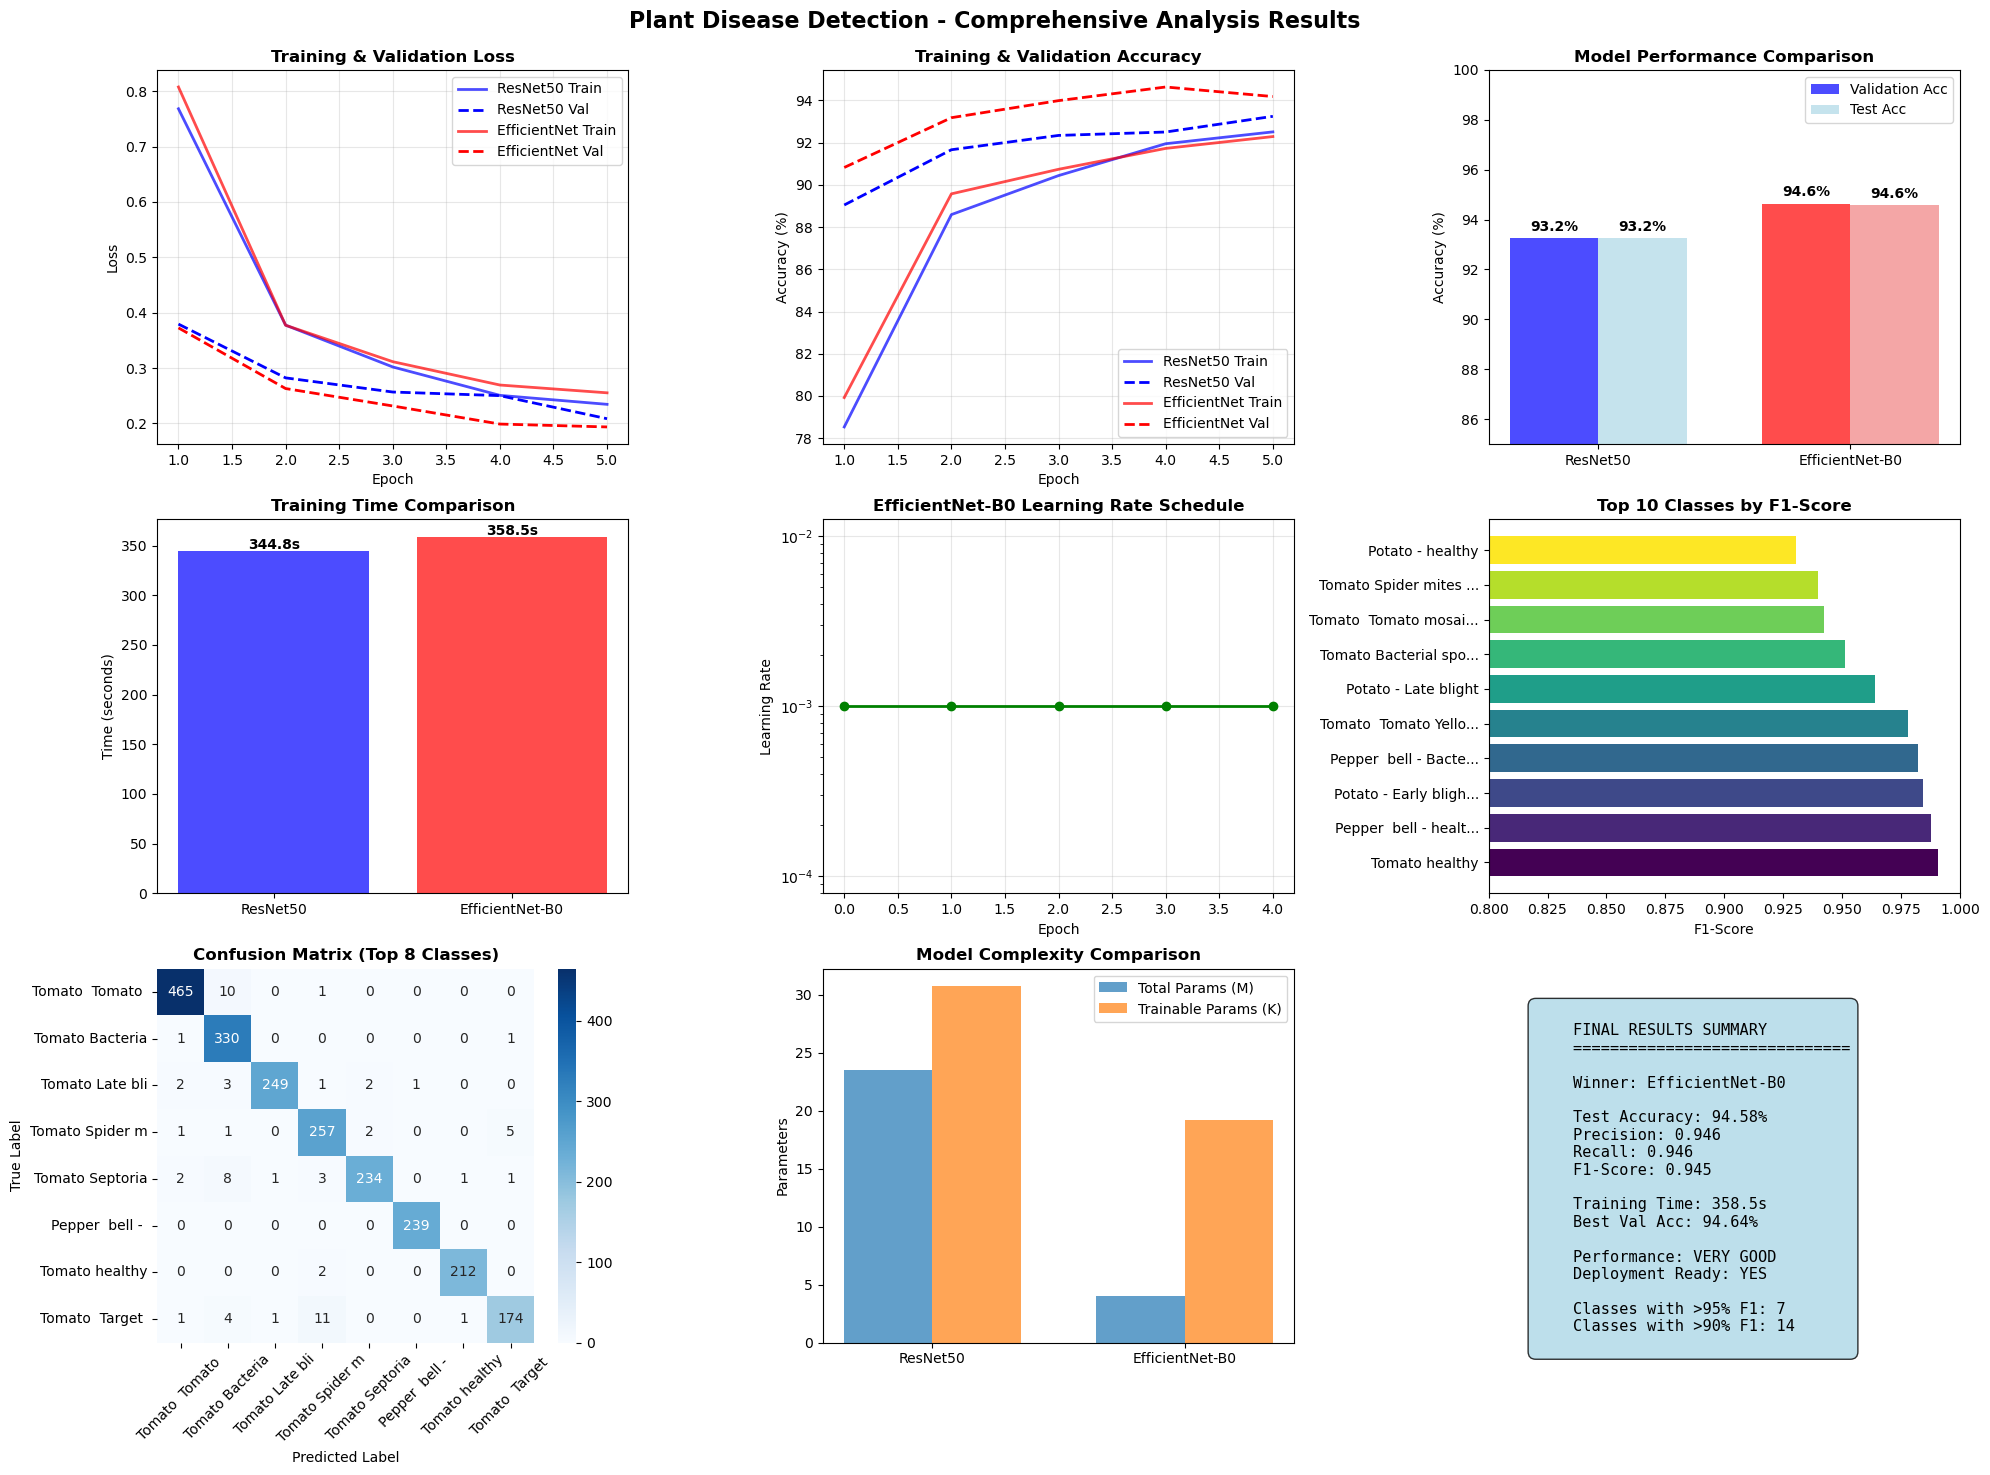

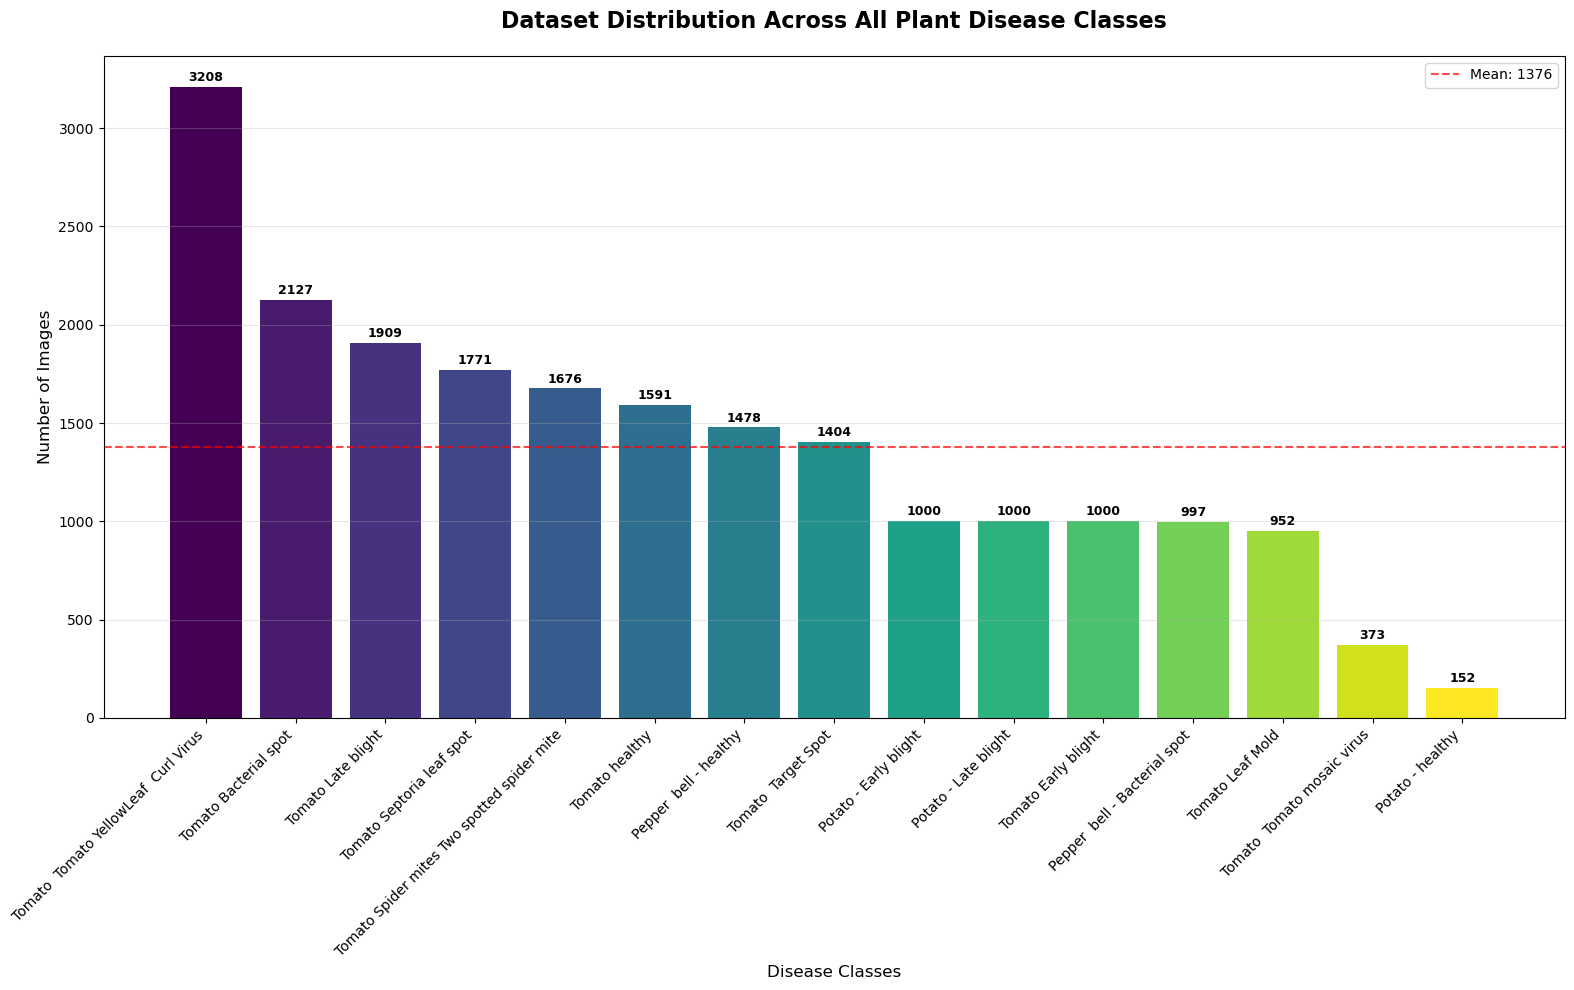

Comprehensive analysis complete


In [18]:
def create_comprehensive_visualization():
    """
    Create comprehensive visualization of training results and model comparison
    """
    
    # Create a large figure with multiple subplots
    fig = plt.figure(figsize=(20, 15))
    
    # Define epochs for plotting
    resnet_epochs = range(1, len(resnet_history['train_losses']) + 1)
    efficient_epochs = range(1, len(efficientnet_history['train_losses']) + 1)
    
    # 1. Training and Validation Loss Comparison
    plt.subplot(3, 3, 1)
    plt.plot(resnet_epochs, resnet_history['train_losses'], 'b-', linewidth=2, label='ResNet50 Train', alpha=0.7)
    plt.plot(resnet_epochs, resnet_history['val_losses'], 'b--', linewidth=2, label='ResNet50 Val')
    plt.plot(efficient_epochs, efficientnet_history['train_losses'], 'r-', linewidth=2, label='EfficientNet Train', alpha=0.7)
    plt.plot(efficient_epochs, efficientnet_history['val_losses'], 'r--', linewidth=2, label='EfficientNet Val')
    plt.title('Training & Validation Loss', fontsize=12, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 2. Training and Validation Accuracy Comparison
    plt.subplot(3, 3, 2)
    plt.plot(resnet_epochs, resnet_history['train_accuracies'], 'b-', linewidth=2, label='ResNet50 Train', alpha=0.7)
    plt.plot(resnet_epochs, resnet_history['val_accuracies'], 'b--', linewidth=2, label='ResNet50 Val')
    plt.plot(efficient_epochs, efficientnet_history['train_accuracies'], 'r-', linewidth=2, label='EfficientNet Train', alpha=0.7)
    plt.plot(efficient_epochs, efficientnet_history['val_accuracies'], 'r--', linewidth=2, label='EfficientNet Val')
    plt.title('Training & Validation Accuracy', fontsize=12, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 3. Model Comparison Bar Chart
    plt.subplot(3, 3, 3)
    models = ['ResNet50', 'EfficientNet-B0']
    val_accuracies = [resnet_history['best_val_acc'], efficientnet_history['best_val_acc']]
    test_accuracies = [0, test_results['test_accuracy']]  # Only winner tested
    
    x = np.arange(len(models))
    width = 0.35
    
    bars1 = plt.bar(x - width/2, val_accuracies, width, label='Validation Acc', color=['blue', 'red'], alpha=0.7)
    bars2 = plt.bar(x + width/2, [val_accuracies[0], test_results['test_accuracy']], width, 
                   label='Test Acc', color=['lightblue', 'lightcoral'], alpha=0.7)
    
    plt.title('Model Performance Comparison', fontsize=12, fontweight='bold')
    plt.ylabel('Accuracy (%)')
    plt.xticks(x, models)
    plt.legend()
    plt.ylim(85, 100)
    
    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            if height > 0:  # Only show labels for non-zero values
                plt.text(bar.get_x() + bar.get_width()/2., height + 0.3,
                        f'{height:.1f}%', ha='center', fontweight='bold')
    
    # 4. Training Time Comparison
    plt.subplot(3, 3, 4)
    training_times = [resnet_history['training_time'], efficientnet_history['training_time']]
    colors = ['blue', 'red']
    bars = plt.bar(models, training_times, color=colors, alpha=0.7)
    plt.title('Training Time Comparison', fontsize=12, fontweight='bold')
    plt.ylabel('Time (seconds)')
    for bar, time_val in zip(bars, training_times):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2,
                f'{time_val:.1f}s', ha='center', fontweight='bold')
    
    # 5. Learning Rate Schedule (Winner Model)
    plt.subplot(3, 3, 5)
    plt.plot(winner_history['learning_rates'], 'g-', linewidth=2, marker='o')
    plt.title(f'{winner_name} Learning Rate Schedule', fontsize=12, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.yscale('log')
    plt.grid(True, alpha=0.3)
    
    # 6. Per-Class F1 Scores (Top 10)
    plt.subplot(3, 3, 6)
    top_classes = sorted(class_performance, key=lambda x: x['f1'], reverse=True)[:10]
    class_names_short = [cls['class'][:20] + '...' if len(cls['class']) > 20 else cls['class'] 
                        for cls in top_classes]
    f1_scores = [cls['f1'] for cls in top_classes]
    
    bars = plt.barh(class_names_short, f1_scores, color=plt.cm.viridis(np.linspace(0, 1, len(f1_scores))))
    plt.title('Top 10 Classes by F1-Score', fontsize=12, fontweight='bold')
    plt.xlabel('F1-Score')
    plt.xlim(0.8, 1.0)
    
    # 7. Confusion Matrix Heatmap (simplified - top 8 classes)
    plt.subplot(3, 3, 7)
    top_8_indices = [class_names.index(cls['class'].replace(' - ', '___').replace(' ', '_')) 
                     for cls in class_performance[:8]]
    cm_subset = confusion_matrix_data[np.ix_(top_8_indices, top_8_indices)]
    
    sns.heatmap(cm_subset, annot=True, fmt='d', cmap='Blues', 
                xticklabels=[cls['class'][:15] for cls in class_performance[:8]],
                yticklabels=[cls['class'][:15] for cls in class_performance[:8]])
    plt.title('Confusion Matrix (Top 8 Classes)', fontsize=12, fontweight='bold')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    
    # 8. Model Architecture Comparison
    plt.subplot(3, 3, 8)
    architectures = ['ResNet50', 'EfficientNet-B0']
    trainable_params = [resnet_trainable, efficient_trainable]
    total_params = [resnet_total, efficient_total]
    
    x = np.arange(len(architectures))
    width = 0.35
    
    plt.bar(x - width/2, [p/1e6 for p in total_params], width, label='Total Params (M)', alpha=0.7)
    plt.bar(x + width/2, [p/1e3 for p in trainable_params], width, label='Trainable Params (K)', alpha=0.7)
    plt.title('Model Complexity Comparison', fontsize=12, fontweight='bold')
    plt.ylabel('Parameters')
    plt.xticks(x, architectures)
    plt.legend()
    
    # 9. Performance Summary
    plt.subplot(3, 3, 9)
    plt.axis('off')
    
    # Create summary text
    summary_text = f"""
    FINAL RESULTS SUMMARY
    {'='*30}
    
    Winner: {winner_name}
    
    Test Accuracy: {test_results['test_accuracy']:.2f}%
    Precision: {test_results['precision_weighted']:.3f}
    Recall: {test_results['recall_weighted']:.3f}
    F1-Score: {test_results['f1_weighted']:.3f}
    
    Training Time: {winner_history['training_time']:.1f}s
    Best Val Acc: {winner_history['best_val_acc']:.2f}%
    
    Performance: {performance_level}
    Deployment Ready: {'YES' if test_results['test_accuracy'] >= 90 else 'NO'}
    
    Classes with >95% F1: {excellent_classes}
    Classes with >90% F1: {good_classes + excellent_classes}
    """
    
    plt.text(0.1, 0.9, summary_text, transform=plt.gca().transAxes, 
             fontsize=11, verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle='round,pad=0.5', facecolor='lightblue', alpha=0.8))
    
    plt.tight_layout()
    plt.suptitle('Plant Disease Detection - Comprehensive Analysis Results', 
                 fontsize=16, fontweight='bold', y=0.98)
    plt.subplots_adjust(top=0.94)
    plt.show()

# Generate comprehensive visualization
print("Generating comprehensive visualization...")
create_comprehensive_visualization()

def plot_class_distribution_detailed():
    """
    Create detailed class distribution visualization
    """
    plt.figure(figsize=(16, 10))
    
    # Prepare data
    class_names_clean = [name.replace('___', ' - ').replace('_', ' ') for name in class_names]
    counts = [class_counts[name] for name in class_names]
    
    # Sort by count for better visualization
    sorted_data = sorted(zip(class_names_clean, counts), key=lambda x: x[1], reverse=True)
    sorted_classes, sorted_counts = zip(*sorted_data)
    
    # Create bar plot with color gradient
    colors = plt.cm.viridis(np.linspace(0, 1, len(sorted_classes)))
    bars = plt.bar(range(len(sorted_classes)), sorted_counts, color=colors)
    
    plt.title('Dataset Distribution Across All Plant Disease Classes', 
              fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Disease Classes', fontsize=12)
    plt.ylabel('Number of Images', fontsize=12)
    
    # Rotate labels for better readability
    plt.xticks(range(len(sorted_classes)), sorted_classes, rotation=45, ha='right')
    
    # Add value labels on bars
    for i, (bar, count) in enumerate(zip(bars, sorted_counts)):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 30, 
                str(count), ha='center', fontsize=9, fontweight='bold')
    
    # Add statistics
    mean_count = np.mean(sorted_counts)
    plt.axhline(y=mean_count, color='red', linestyle='--', alpha=0.7, 
                label=f'Mean: {mean_count:.0f}')
    plt.legend()
    
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

# Create detailed class distribution plot
plot_class_distribution_detailed()

print("Comprehensive analysis complete")

## FINAL RESULTS SUMMARY AND CONCLUSIONS

In [19]:
def generate_final_report():
    """
    Generate comprehensive final report with all key findings
    """
    
    print(f"\n{'='*80}")
    print(f"              PLANT DISEASE DETECTION - FINAL REPORT")
    print(f"{'='*80}")
    
    print(f"\nPROJECT OVERVIEW:")
    print(f"  Dataset: PlantVillage Plant Disease Dataset")
    print(f"  Total Images: {total_images:,}")
    print(f"  Disease Classes: {num_classes}")
    print(f"  Task: Multi-class image classification")
    print(f"  Approach: Transfer learning with pre-trained CNN models")
    
    print(f"\nDATASET CHARACTERISTICS:")
    print(f"  Largest class: {sorted_counts[0][1]:,} images")
    print(f"  Smallest class: {sorted_counts[-1][1]:,} images")
    print(f"  Imbalance ratio: {sorted_counts[0][1] / sorted_counts[-1][1]:.1f}:1")
    print(f"  Split ratio: 70% train, 15% validation, 15% test")
        
    print(f"\nTRAINING CONFIGURATION:")
    print(f"  Transfer learning approach: Feature extraction")
    print(f"  Optimizer: Adam with learning rate {learning_rate}")
    print(f"  Loss function: CrossEntropyLoss")
    print(f"  Batch size: {batch_size}")
    print(f"  Data augmentation: Flip, rotation, color jitter, affine transforms")
    print(f"  Learning rate scheduling: ReduceLROnPlateau")
    
    print(f"\nTRAINING RESULTS:")
    print(f"  ResNet50:")
    print(f"    Best validation accuracy: {resnet_history['best_val_acc']:.2f}%")
    print(f"    Training time: {resnet_history['training_time']:.2f}s")
    print(f"    Epochs completed: {resnet_history['total_epochs']}")
    print(f"  EfficientNet-B0:")
    print(f"    Best validation accuracy: {efficientnet_history['best_val_acc']:.2f}%")
    print(f"    Training time: {efficientnet_history['training_time']:.2f}s")
    print(f"    Epochs completed: {efficientnet_history['total_epochs']}")
    
    print(f"\nWINNER: {winner_name}")
    improvement = winner_history['best_val_acc'] - (resnet_history['best_val_acc'] if winner_name == 'EfficientNet-B0' else efficientnet_history['best_val_acc'])
    print(f"  Performance advantage: +{improvement:.2f}%")
    
    print(f"\nFINAL TEST SET EVALUATION:")
    print(f"  Test accuracy: {test_results['test_accuracy']:.2f}%")
    print(f"  Weighted precision: {test_results['precision_weighted']:.4f}")
    print(f"  Weighted recall: {test_results['recall_weighted']:.4f}")
    print(f"  Weighted F1-score: {test_results['f1_weighted']:.4f}")
    print(f"  Macro precision: {test_results['precision_macro']:.4f}")
    print(f"  Macro recall: {test_results['recall_macro']:.4f}")
    print(f"  Macro F1-score: {test_results['f1_macro']:.4f}")
    
    print(f"\nCLASS PERFORMANCE ANALYSIS:")
    print(f"  Classes with excellent performance (F1 > 0.95): {excellent_classes}")
    print(f"  Classes with good performance (F1 > 0.90): {good_classes}")
    print(f"  Classes needing improvement (F1 < 0.90): {poor_classes}")
    
    # Identify best and worst performing classes
    best_class = max(class_performance, key=lambda x: x['f1'])
    worst_class = min(class_performance, key=lambda x: x['f1'])
    
    print(f"  Best performing class: {best_class['class']} (F1: {best_class['f1']:.3f})")
    print(f"  Most challenging class: {worst_class['class']} (F1: {worst_class['f1']:.3f})")

# Generate final comprehensive report
generate_final_report()

# Save important metrics for reporting
final_metrics = {
    'dataset_size': total_images,
    'num_classes': num_classes,
    'winner_model': winner_name,
    'test_accuracy': test_results['test_accuracy'],
    'precision': test_results['precision_weighted'],
    'recall': test_results['recall_weighted'],
    'f1_score': test_results['f1_weighted'],
    'training_time': winner_history['training_time'],
    'validation_accuracy': winner_history['best_val_acc'],
    'excellent_classes': excellent_classes,
    'good_classes': good_classes,
    'poor_classes': poor_classes
}

print(f"\nAll analyses completed successfully")


              PLANT DISEASE DETECTION - FINAL REPORT

PROJECT OVERVIEW:
  Dataset: PlantVillage Plant Disease Dataset
  Total Images: 20,638
  Disease Classes: 15
  Task: Multi-class image classification
  Approach: Transfer learning with pre-trained CNN models

DATASET CHARACTERISTICS:
  Largest class: 3,208 images
  Smallest class: 152 images
  Imbalance ratio: 21.1:1
  Split ratio: 70% train, 15% validation, 15% test

TRAINING CONFIGURATION:
  Transfer learning approach: Feature extraction
  Optimizer: Adam with learning rate 0.001
  Loss function: CrossEntropyLoss
  Batch size: 32
  Data augmentation: Flip, rotation, color jitter, affine transforms
  Learning rate scheduling: ReduceLROnPlateau

TRAINING RESULTS:
  ResNet50:
    Best validation accuracy: 93.25%
    Training time: 344.82s
    Epochs completed: 5
  EfficientNet-B0:
    Best validation accuracy: 94.64%
    Training time: 358.51s
    Epochs completed: 5

WINNER: EfficientNet-B0
  Performance advantage: +1.39%

FINAL TE